In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import os
import gc
from scipy.stats import kurtosis
from tqdm import tqdm

In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence.

# Load Data

In [2]:
train = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-apr-2022/test.csv')
print(train.shape)
print(test.shape)

sub = pd.read_csv('../input/tabular-playground-series-apr-2022/sample_submission.csv')
print(sub.shape)

train_labels = pd.read_csv('../input/tabular-playground-series-apr-2022/train_labels.csv')
print('label', train_labels.shape)

(1558080, 16)
(733080, 16)
(12218, 2)
label (25968, 2)


In [3]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


# Files and Field Descriptions
train.csv - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants
* sequence - a unique id for each sequence
* subject - a unique id for the subject in the experiment
* step - time step of the recording, in one second intervals
* sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step

train_labels.csv - the class label for each sequence.
* sequence - the unique id for each sequence.
* state - the state associated to each sequence. This is the target which you are trying to predict.

test.csv - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.
* sample_submission.csv - a sample submission file in the correct format.

# FE

In [4]:
scols = [c for c in train.columns if 'sensor' in c ]
scols

['sensor_00',
 'sensor_01',
 'sensor_02',
 'sensor_03',
 'sensor_04',
 'sensor_05',
 'sensor_06',
 'sensor_07',
 'sensor_08',
 'sensor_09',
 'sensor_10',
 'sensor_11',
 'sensor_12']

In [5]:
from scipy.stats import kurtosis, iqr
def kurtosis_func(series):
    '''
    Describe something...
    '''
    return kurtosis(series)

def iqr_func(series):
    return iqr(series)

In [6]:
%%time

train['colmean'] = train[scols].mean(axis = 1)
train['colstd'] = train[scols].std(axis = 1)

train_agg = train.groupby(['sequence','subject'])[scols].agg(['mean','std','min','max'])
train_agg.columns = ["_".join(x) for x in train_agg.columns.ravel()]
train_agg = train_agg.reset_index()
train_agg = train_agg.merge(train_labels)
train_agg['seq_cnt'] = train_agg.groupby('subject')['sequence'].transform('size')

for c in tqdm(scols):
    train_agg['kurt_'+ c] = train.groupby(['sequence','subject'])[c].apply(kurtosis).values
    
    train_agg['iqr_' + c] = train.groupby(['sequence','subject'])[c].apply(iqr_func).values
    
print(train_agg.shape)
train_agg.head()

100%|██████████| 13/13 [01:57<00:00,  9.06s/it]

(25968, 82)
CPU times: user 1min 58s, sys: 1.03 s, total: 1min 59s
Wall time: 1min 59s


,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_min,sensor_00_max,sensor_01_mean,sensor_01_std,sensor_01_min,sensor_01_max,...,kurt_sensor_08,iqr_sensor_08,kurt_sensor_09,iqr_sensor_09,kurt_sensor_10,iqr_sensor_10,kurt_sensor_11,iqr_sensor_11,kurt_sensor_12,iqr_sensor_12
0,0,47,0.041744,1.431660,-5.634467,7.534003,-0.013025,1.509221,-3.002101,3.623950,...,-0.403691,1.425,-0.089246,1.309249,-0.513776,1.247553,-0.012706,1.341049,21.285187,6.099957
1,1,66,-0.069294,1.593907,-6.657651,5.870943,-0.019958,0.949403,-2.745798,2.525210,...,0.127919,1.300,2.253551,1.024566,19.969010,0.884557,5.656813,1.069187,3.088862,0.396526
2,2,66,-0.001546,1.147526,-2.797527,3.402628,0.025000,0.803884,-1.733193,2.321429,...,1.949469,1.175,2.195867,0.787030,7.386540,0.737545,0.490734,0.787037,1.936414,0.356991
3,3,542,0.029869,1.769705,-3.643740,4.856260,-0.049177,1.914868,-5.860294,6.722689,...,0.367865,2.400,0.921675,3.703215,3.894959,0.379938,0.701239,1.101852,2.122750,0.233163
4,4,437,0.059132,2.014779,-5.331530,5.455951,0.014916,1.385251,-5.898109,3.532563,...,0.188311,1.150,1.659885,1.124819,-1.208661,0.605028,0.291986,2.761831,-0.001164,0.057971


# Correlation Analysis

In [7]:
train_agg.corr()['state'].abs().sort_values(ascending = False)

state             1.000000
seq_cnt           0.368076
kurt_sensor_04    0.317900
kurt_sensor_10    0.254715
kurt_sensor_11    0.188112
                    ...   
sensor_07_mean    0.003675
sensor_05_std     0.002744
sensor_03_mean    0.001918
sensor_00_min     0.001893
sensor_07_std     0.001254
Name: state, Length: 82, dtype: float64

In [8]:
%%time

test['colmean'] = test[scols].mean(axis = 1)
test['colstd'] = test[scols].std(axis = 1)

test_agg = test.groupby(['sequence','subject'])[scols].agg(['mean','std','min','max'])
test_agg.columns = ["_".join(x) for x in test_agg.columns.ravel()]
test_agg = test_agg.reset_index()
test_agg['seq_cnt'] = test_agg.groupby('subject')['sequence'].transform('size')

for c in tqdm(scols):
    test_agg['kurt_'+ c] = test.groupby(['sequence','subject'])[c].apply(kurtosis).values
    test_agg['iqr_' + c] = test.groupby(['sequence','subject'])[c].apply(iqr_func).values
    
print(test_agg.shape)
test_agg.head()


100%|██████████| 13/13 [00:55<00:00,  4.28s/it]

(12218, 81)
CPU times: user 56.2 s, sys: 175 ms, total: 56.3 s
Wall time: 56.4 s


,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_min,sensor_00_max,sensor_01_mean,sensor_01_std,sensor_01_min,sensor_01_max,...,kurt_sensor_08,iqr_sensor_08,kurt_sensor_09,iqr_sensor_09,kurt_sensor_10,iqr_sensor_10,kurt_sensor_11,iqr_sensor_11,kurt_sensor_12,iqr_sensor_12
0,25968,684,-0.002602,1.091741,-4.950541,3.146832,-0.036432,4.499484,-21.747899,19.639706,...,2.033689,2.250,0.467456,0.952854,11.702361,0.615995,8.088929,1.048868,-0.293747,0.439258
1,25969,935,0.028516,1.450040,-3.675425,5.816074,0.002276,0.775379,-2.259454,1.763655,...,-0.044299,0.900,1.191125,0.688764,-0.222143,0.618827,1.753780,0.980453,-1.044935,1.062553
2,25970,924,0.057664,5.083618,-15.005410,12.306028,-0.021796,2.903657,-5.611345,5.900210,...,-0.067345,0.725,-0.078528,2.352782,-1.426722,5.706731,1.509805,3.298611,-1.158939,31.323423
3,25971,769,-0.004791,0.914917,-2.465997,2.876352,0.014863,0.950923,-2.591387,2.435924,...,1.710135,0.800,1.137138,0.564848,2.289931,0.413716,1.373066,0.558128,-0.497098,1.598998
4,25972,764,-0.001443,2.783685,-9.974498,17.295209,-0.025350,23.942241,-136.376050,115.925420,...,12.109514,1.000,26.070890,1.001445,0.723371,4.298331,27.719859,0.967850,-0.731940,248.652387


# Pre-processing

In [9]:
X_train = train_agg.drop(['state','sequence','subject'], axis = 1)
y_train = train_agg.state
print(X_train.shape)
X_test = test_agg.drop(['sequence','subject'], axis = 1)
print(X_test.shape)

grp = train_agg.subject

(25968, 79)
(12218, 79)


In [10]:
train_agg.subject.value_counts()

437    199
1      175
635    158
647    144
87     129
      ... 
486      7
519      7
265      6
73       5
472      2
Name: subject, Length: 672, dtype: int64

# LGBM

In [11]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2022)
gkf = GroupKFold(n_splits = 5)
preds = np.zeros(len(sub))
oof = np.zeros(len(X_train))

for i, (idxt, idxv) in enumerate(skf.split(X_train, y_train)):
#for i, (idxt, idxv) in enumerate(gkf.split(X_train, groups = grp)):
    
    print('Fold', i+1)
    print('*' * 50)
    
    X_trn, X_val = X_train.iloc[idxt], X_train.iloc[idxv]
    y_trn, y_val = y_train.iloc[idxt], y_train.iloc[idxv]

    clf = lgb.LGBMClassifier(

        n_estimators = 2000,
        learning_rate = 0.05,
        subsample = 0.8,
        colsample_bytree = 0.8,
        reg_alpha = 1,
         importance_type = 'gain',
        )
    
    clf.fit(X_trn, y_trn, eval_set = [(X_trn, y_trn), (X_val, y_val)], eval_metric = ['auc'], verbose = 100,
           early_stopping_rounds=100)

    oof[idxv] = clf.predict_proba(X_val)[:,1]
    preds += clf.predict_proba(X_test)[:,1]/skf.n_splits
    
print('OOF ROC', roc_auc_score(y_train, oof))     

Fold 1
**************************************************
[100]	training's auc: 0.950777	training's binary_logloss: 0.304896	valid_1's auc: 0.919397	valid_1's binary_logloss: 0.359345
[200]	training's auc: 0.973661	training's binary_logloss: 0.238835	valid_1's auc: 0.926351	valid_1's binary_logloss: 0.33764
[300]	training's auc: 0.986262	training's binary_logloss: 0.198242	valid_1's auc: 0.928131	valid_1's binary_logloss: 0.332669
[400]	training's auc: 0.993083	training's binary_logloss: 0.168419	valid_1's auc: 0.928695	valid_1's binary_logloss: 0.330917
[500]	training's auc: 0.996702	training's binary_logloss: 0.144142	valid_1's auc: 0.92935	valid_1's binary_logloss: 0.329359
[600]	training's auc: 0.99866	training's binary_logloss: 0.123886	valid_1's auc: 0.929796	valid_1's binary_logloss: 0.328667
[700]	training's auc: 0.999531	training's binary_logloss: 0.106596	valid_1's auc: 0.930496	valid_1's binary_logloss: 0.327742
[800]	training's auc: 0.999858	training's binary_logloss: 0.092

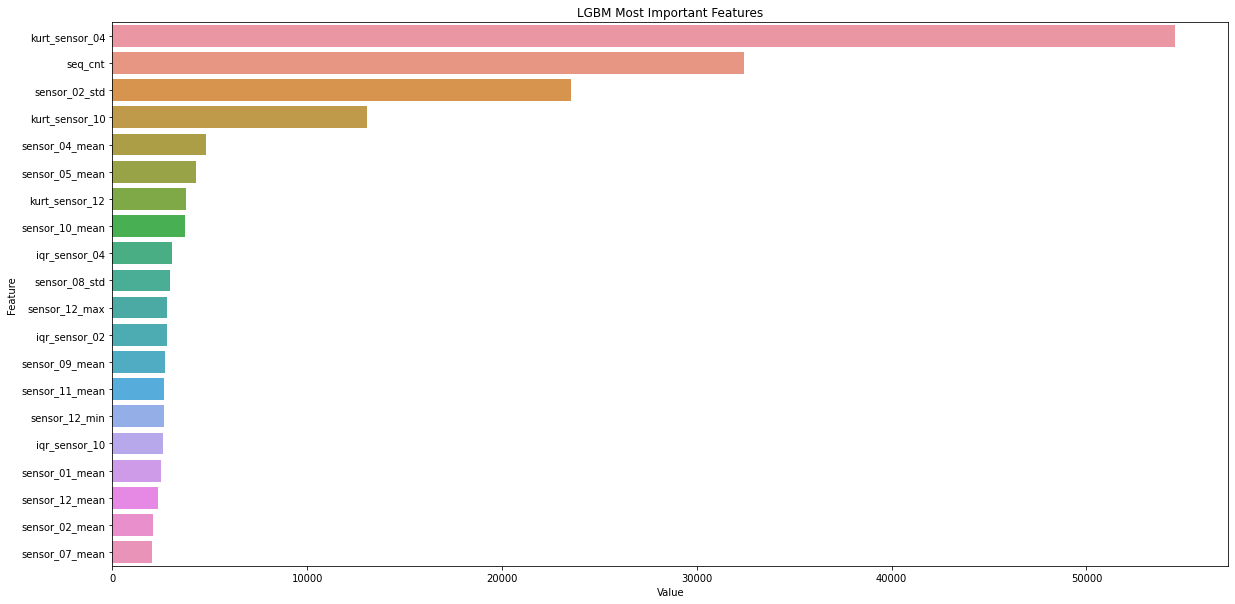

In [12]:
cols = list(X_train.columns)
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:20])
plt.title('LGBM Most Important Features')
#plt.tight_layout()
plt.show()

# Submission

In [13]:
sub.state = preds
sub

,sequence,state
0,25968,0.926708
1,25969,0.976557
2,25970,0.003733
3,25971,0.845711
4,25972,0.616048
...,...,...
12213,38181,0.894553
12214,38182,0.371089
12215,38183,0.762352
12216,38184,0.009430


In [14]:
sub.to_csv('lgb_submission.csv', index = False)